<a href="https://colab.research.google.com/github/PaulToronto/AI-and-Machine-Learning-for-Coders---Book/blob/main/1__Introduction_to_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow

## Chips

- **CPU**: Central Processing Unit
- **GPU**: Graphics Processing Unit
- **TPU**: Tensor Processing Unit

Models are usually traind with just a single chip, but in more advanced environments, parallel traing across chiops can be used, employing a **distribution strategy** where traian spans multiple chips. TensorFlow supports this.

## A "Hello, World" program

A neural network with just one layer with a single node.

### Imports

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

### The data

- By examination, we can see that `y = 2x - 1`, but we want an ML model to figure that out.
- This is a linear equation of the form `y = wx + b`
- The weights for this linear equation are `w` and `b`, which are equal to `2` and `-1` respectively.

In [2]:
x = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
y = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

### The model

In [3]:
# Build the model
model = Sequential([
    Input(shape=(1, )),
    Dense(units=1)      # the default activation for the Dense layer is
                        #. `None` which is linear activation, a(x) = x
])

# Compile the model
model.compile(optimizer='sgd',
              loss='mean_squared_error')

# Train the model
history = model.fit(x, y, epochs=500, verbose=0)

# Predict using the model
model.predict(np.array([10.0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[18.98021]], dtype=float32)

In [4]:
model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[-2.9882386],
       [-0.9911069],
       [ 1.0060246],
       [ 3.0031562],
       [ 5.000288 ],
       [ 6.9974194]], dtype=float32)

### Weight and Bias

- `y = wx + b`
- the weight is reprsented by `w` and the bias by `b`

In [5]:
# weight and bias learned by our model
w, b = model.layers[0].get_weights()

In [6]:
w = w[0,0]
b = b[0]
w, b

(1.9971316, -0.9911069)

In [7]:
w * x + b # same as `model.predict(x)`

array([-2.98823851, -0.99110693,  1.00602466,  3.00315624,  5.00028783,
        6.99741942])

## Extra

The rest of this notebook is maaterial that was not in the book's chapter. These are my own experiments that I've done to increase my understanding of the material.

### Imports

In [8]:
import matplotlib.pyplot as plt

### The history callback

- The model's `fit()` method returns an object of type `keras.src.callbacks.history.History`
- This object has a property, `history` which is a dictionary
- By default, this dictionary tracks the 'loss' during training


In [9]:
history.history.keys()

dict_keys(['loss'])

In [10]:
epochs = range(1, len(history.history['loss']) + 1)
epochs

range(1, 501)

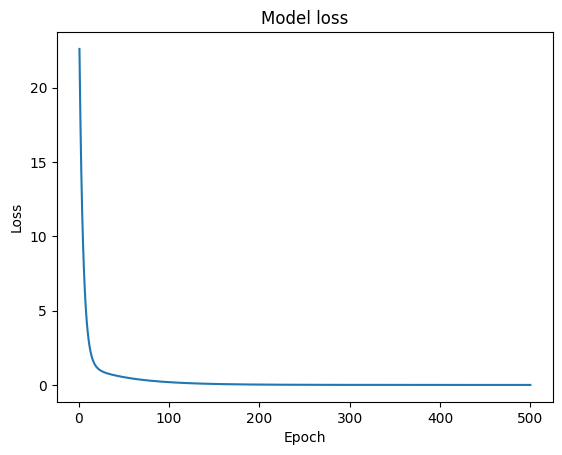

In [11]:
plt.plot(epochs, history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### How to capture weights and biase for each epoch

1. Create a custom callback by subclassing `tf.keras.callbacks.Callback`
2. Override the `on_train_begin` method to capture the initial random weights and biases right after the model is built
3. Override the `on_epoch_end` method to capture the weights and biase at the end of each epoch

In [12]:
class WeightsBiasesLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(WeightsBiasesLogger, self).__init__()
        self.weights = []
        self.biases = []

    def on_train_begin(self, logs=None):
        # Get the initial weights and biases before training starts
        weights, biases = self.model.layers[0].get_weights()
        self.weights.append(weights.copy())
        self.biases.append(biases.copy())
        #print(f"Initial : Weights = {weights}, Biases = {biases}")

    def on_epoch_end(self, epoch, logs=None):
        # Get weights and biases from the Dense layer
        #. after each epoch
        weights, biases = self.model.layers[0].get_weights()
        self.weights.append(weights.copy())
        self.biases.append(biases.copy())
        #print(f"Epoch {epoch + 1}: Weights = {weights}, Biases = {biases}")

In [13]:
# Build the model
model = Sequential([
    Input(shape=(1, )),
    Dense(units=1)      # the default activation for the Dense layer is
                        #. `None` which is linear activation, a(x) = x
])

# Compile the model
model.compile(optimizer='sgd',
              loss='mean_squared_error')

# Instantiate the custom callback
weights_biases_logger = WeightsBiasesLogger()

# Train the model: same as before but with `callbacks` parameter
history = model.fit(x, y, epochs=500, verbose=0,
                    callbacks=[weights_biases_logger])

### Plotting the history

In [14]:
# put weights and baises into lists
weights = np.array([weight.flatten()[0] for weight in weights_biases_logger.weights])
biases = np.array([bias.flatten()[0] for bias in weights_biases_logger.biases])

initial_w = weights[0]
initial_b = biases[0]

weights = weights[1:]
biases = biases[1:]
epochs = np.arange(1, 501)
# recall we have our losses as well from the history.history dictionary
losses = np.array(history.history['loss'].copy())

# reduce the size of these arrays so the graph is not too cluttered
keep_indices = np.array([0, 4, 9, 19, 29, 39, 49, 99, 149, 199, 299, 399, 499])
weights = weights[keep_indices]
biases=biases[keep_indices]
epochs = epochs[keep_indices]
losses = losses[keep_indices]

# different color for each epoch
colors = plt.cm.jet(np.linspace(0, 1, len(epochs)))

# zip weights, biases and colors
weights_biases_colors = list(zip(weights, biases, colors))

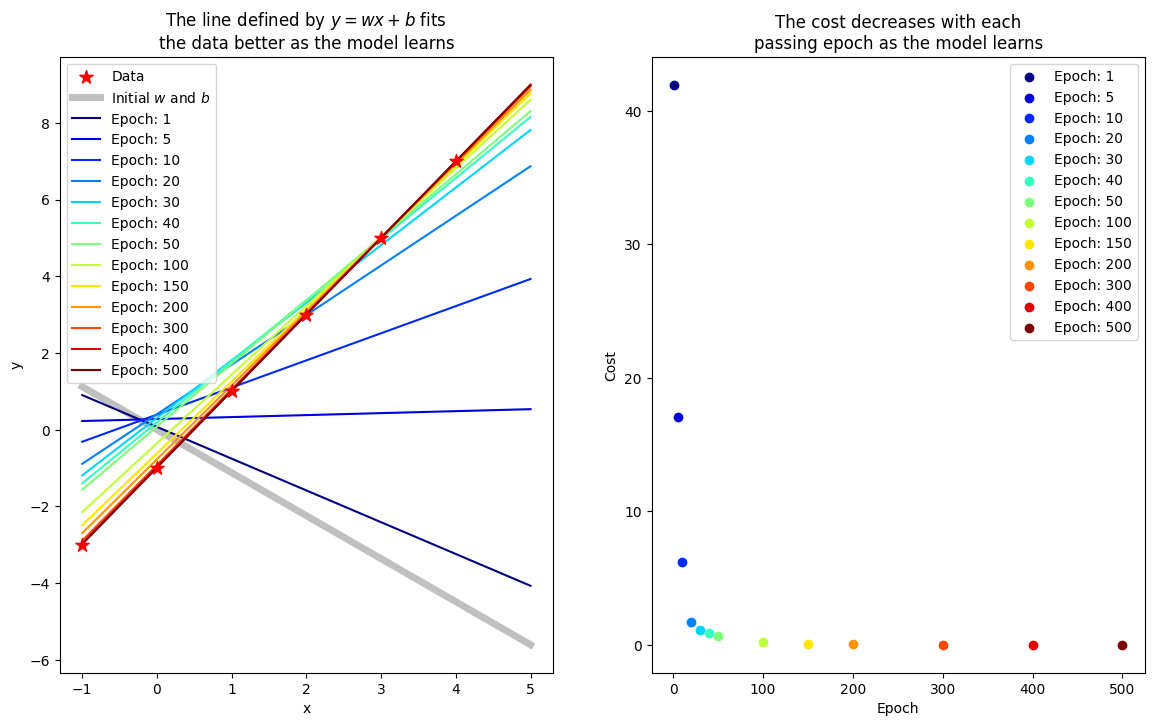

In [15]:
xs = np.linspace(int(x.min()), int(x.max()) + 1, len(epochs))
# lines for each weight and bias pair
f = lambda w, b: w * xs + b

plt.figure(figsize=(14, 8))

# left plot
plt.subplot(1, 2, 1)
# plot the data
plt.scatter(x, y, color='red', s=100, marker='*', label='Data', zorder=100)
# plot line for the initial `w` and `b`
plt.plot(xs, f(initial_w, initial_b), color='silver', linewidth=5, label='Initial $w$ and $b$')
# plot the rest of the lines
for i, (w, b, c) in enumerate(weights_biases_colors):
    plt.plot(xs, f(w, b), color=c, label=f'Epoch: {epochs[i]}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('The line defined by $y=wx +b$ fits\nthe data better as the model learns')
plt.legend()

# right plot
plt.subplot(1, 2, 2)
for i, loss in enumerate(losses):
    plt.scatter(epochs[i], losses[i], color=colors[i], label=f'Epoch: {epochs[i]}')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('The cost decreases with each\npassing epoch as the model learns')
plt.legend()

plt.show()